In [1]:
import h5py
import math
import random
import numpy as np
import seaborn as sns
import scipy.signal as signal
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import invgamma

In [2]:
# 一些全局变量，放在这里好设置

# SHM-Data的位置
SHM_Data_Locate = "D://SHM-Data/"

# 连续小波变换的输入宽度
tof_widths = 101

# 12组传感器的xy坐标
sensor_locate = np.array([[450, 470], [370, 470], [290, 470], [210, 470], [130, 470], [50, 470], [450, 30], [370, 30], [290, 30], [210, 30], [130, 30], [50, 30]])

# 28个缺陷的位置
damage_locate = np.array([
    [50, 415], [65, 415], [50, 400], [65, 400],
    [250, 427], [265, 427], [250,412], [265, 412],
    [180, 345], [195, 345], [180,330], [195, 345],
    [320, 275], [335, 275], [320, 260], [335, 275],
    [130, 195], [145, 195], [130, 180], [130, 180],
    [435, 205], [450, 205], [435, 190], [450, 190],
    [250, 90], [265, 90], [250, 75], [265, 75]
])

# MCMC总运行次数
NT = 10000

# MCMC老化时间
NB = 150

# 先验概率密度函数
[def_p_x, def_p_y, def_p_v] = [180, 345, 2000]
[def_p_x_scale, def_p_y_scale, def_p_v_scale] = [10, 10, 100]

In [3]:
# 使用连续小波变换获取ToF时间
# 输入catch信号和频道，输出ToF时间
def def_tof(def_tof_catch, def_tof_channel):
    def_tof_data = def_tof_catch[()][def_tof_channel, :]
    def_tof_widths = np.arange(1, tof_widths)
    def_tof_data_cwt = signal.cwt(def_tof_data, signal.morlet2, def_tof_widths)
    def_tof_data_cwt = np.square(np.abs(def_tof_data_cwt))
    def_tof_max_x, def_tof_max_y = np.where(def_tof_data_cwt == np.max(def_tof_data_cwt))
    def_tof_select = def_tof_data_cwt[def_tof_max_x, :]
    def_tof_select.resize(13108)
    def_tof_peak = signal.find_peaks(def_tof_select)
    def_tof_tof = def_tof_peak[0][1] - def_tof_peak[0][0]
    return def_tof_tof

In [4]:
# 对所有catch信号获取ToF时间，返回选中的几组
def def_multi_tof(dmt_locate, dmt_array):
    dmt_file = h5py.File(SHM_Data_Locate + dmt_locate, 'r')
    dmt_catch = dmt_file['/pitchcatch/catch']
    dmt_data_list = np.zeros((66,))
    for i in range(0, 66):
        dmt_data_list[i] = def_tof(dmt_catch, i)
    dmt_data_result = np.zeros((12, 12))
    dmt_data_point = 0
    for i in range(0, 12):
        for j in range(i + 1, 12):
            dmt_data_result[i][j] = dmt_data_list[dmt_data_point]
            dmt_data_result[j][i] = dmt_data_list[dmt_data_point]
            dmt_data_point += 1
    dmt_array_x = np.size(dmt_array, 0)
    dmt_data_select = np.zeros(dmt_array_x,)
    for i in range(dmt_array_x):
        dmt_data_select[i] = dmt_data_result[dmt_array[i][0]][dmt_array[i][1]]
    return dmt_data_select

In [5]:
# 先验概率密度函数之比
def fuc_p(fuc_p_theta1, fuc_p_theta2):
    fuc_p_x1 = fuc_p_theta1[0]
    fuc_p_y1 = fuc_p_theta1[1]
    fuc_p_v1 = fuc_p_theta1[2]
    fuc_p_x2 = fuc_p_theta2[0]
    fuc_p_y2 = fuc_p_theta2[1]
    fuc_p_v2 = fuc_p_theta2[2]
    fuc_p1 = stats.norm.pdf(fuc_p_x1, def_p_x, scale=def_p_x_scale) * stats.norm.pdf(fuc_p_y1, def_p_y, scale=def_p_y_scale) * stats.norm.pdf(fuc_p_v1, def_p_v, scale=def_p_v_scale)
    fuc_p2 = stats.norm.pdf(fuc_p_x2, def_p_x, scale=def_p_x_scale) * stats.norm.pdf(fuc_p_y2, def_p_y, scale=def_p_y_scale) * stats.norm.pdf(fuc_p_v2, def_p_v, scale=def_p_v_scale)
    fuc_pp = fuc_p1 / fuc_p2
    return min(1, fuc_pp)

In [6]:
# 计算理论与实际的误差
def fuc_q(fuc_q_theta, def_q_tof, def_q_array):
    xd = fuc_q_theta[0]
    yd = fuc_q_theta[1]
    vg = fuc_q_theta[2]
    count = 0
    def_q_size = np.size(def_q_array, 0)
    for i in range(def_q_size):
        count += np.square(def_q_tof[1] - np.sqrt(np.square(xd - sensor_locate[def_q_array[i][0]][0]) + np.square(yd - sensor_locate[def_q_array[i][0]][1])) / vg - np.sqrt(np.square(xd - sensor_locate[def_q_array[i][1]][0]) + np.square(yd - sensor_locate[def_q_array[i][1]][1])) / vg)
    return count

In [7]:
# 返回符合逆伽马分布的随机数
def fuc_ig(fuc_ig_theta, def_ig_tof, def_ig_array):
    return invgamma.rvs(2.5, scale=(1 / fuc_q(fuc_ig_theta, def_ig_tof, def_ig_array)))

In [8]:
# MCMC方法本体
def def_mcmc(def_mcmc_tof, def_mcmc_array):
    def_theta = np.zeros((NT,3))
    def_theta[0] = [250, 250, 3000]
    LK = [1, 1, 1]
    for i in range(1, NT):
        theta_1 = def_theta[i - 1][0] + 2 * LK[0] * (2 * random.random() - 1)
        theta_2 = def_theta[i - 1][1] + 2 * LK[1] * (2 * random.random() - 1)
        theta_3 = def_theta[i - 1][2] + 2 * LK[2] * (2 * random.random() - 1)
        theta_k = [theta_1, def_theta[i - 1][1], def_theta[i - 1][2]]
        alpha = fuc_p(theta_k, [def_theta[i - 1][0], def_theta[i - 1][1], def_theta[i - 1][2]])
        r = alpha * math.exp(-0.5 * fuc_ig(def_theta[i - 1], def_mcmc_tof, def_mcmc_array) * (fuc_q(theta_k, def_mcmc_tof, def_mcmc_array) - fuc_q([def_theta[i - 1][0], def_theta[i - 1][1], def_theta[i - 1][2]], def_mcmc_tof, def_mcmc_array)))
        R = random.random()
        if R < r:
            def_theta[i][0] = theta_1
            LK[0] = LK[0] * 1.01
        else:
            def_theta[i][0] = def_theta[i - 1][0]
            LK[0] = LK[0] / 1.07
        theta_k = [def_theta[i][0], theta_2, def_theta[i - 1][2]]
        alpha = fuc_p(theta_k, [def_theta[i][0], def_theta[i - 1][1], def_theta[i - 1][2]])
        r = alpha * math.exp(-0.5 * fuc_ig(def_theta[i - 1], def_mcmc_tof, def_mcmc_array) * (fuc_q(theta_k, def_mcmc_tof, def_mcmc_array) - fuc_q([def_theta[i][0], def_theta[i - 1][1], def_theta[i - 1][2]], def_mcmc_tof, def_mcmc_array)))
        R = random.random()
        if R < r:
            def_theta[i][1] = theta_2
            LK[1] = LK[1] * 1.01
        else:
            def_theta[i][1] = def_theta[i - 1][1]
            LK[1] = LK[1] / 1.07
        theta_k = [def_theta[i][0], def_theta[i][1], theta_3]
        alpha = fuc_p(theta_k, [def_theta[i][0], def_theta[i][1], def_theta[i - 1][2]])
        r = alpha * math.exp(-0.5 * fuc_ig(def_theta[i - 1], def_mcmc_tof, def_mcmc_array) * (fuc_q(theta_k, def_mcmc_tof, def_mcmc_array) - fuc_q([def_theta[i][0], def_theta[i][1], def_theta[i - 1][2]], def_mcmc_tof, def_mcmc_array)))
        R = random.random()
        if R < r:
            def_theta[i][2] = theta_3
            LK[2] = LK[2] * 1.01
        else:
            def_theta[i][2] = def_theta[i - 1][2]
            LK[2] = LK[2] / 1.07
    return def_theta

In [9]:
# 制图函数，但是有点小问题
def def_plot_fig(def_pf_theta, def_pf_title):
    def_pf_fig, (def_pf_ax1, def_pf_ax2, def_pf_ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    def_pf_x = np.linspace(0, NT-1, NT)
    def_pf_y1 = def_pf_theta[:, 0]
    def_pf_y2 = def_pf_theta[:, 1]
    def_pf_ax1.set_title('MCMC samples for coordinates of damage location')
    def_pf_ax1.plot(def_pf_x, def_pf_y1, label='x-coordinate')
    def_pf_ax1.plot(def_pf_x, def_pf_y2, label='y-coordinate')
    def_pf_ax1.legend()
    def_pf_ax1.set_ylim([0, 500])
    def_pf_ax1.set_xlabel('simples')
    def_pf_ax1.set_ylabel('location coordinates(mm)')

    def_pf_x_joint, def_pf_x_bins = np.histogram(def_pf_theta[:, 0], bins = np.arange(0, 501, 1))
    def_pf_y_joint, def_pf_y_bins = np.histogram(def_pf_theta[:, 1], bins = np.arange(0, 501, 1))
    def_pf_x_joint.flatten()
    def_pf_y_joint.flatten()
    def_pf_pdf_joint = np.outer(def_pf_x_joint, def_pf_y_joint)
    def_pf_ax2_img = def_pf_ax2.imshow(def_pf_pdf_joint, cmap = 'viridis')
    def_pf_ax2.set_title('MCMC joint PDF of the identified possible damage location')
    def_pf_ax2.set_xlabel('x-coordinate')
    def_pf_ax2.set_ylabel('y-coordinate')

    def_pf_prior = np.linspace(0, 501, 501)
    def_pf_x_prior = stats.norm.pdf(def_pf_prior, def_p_x, scale=def_p_x_scale)
    def_pf_y_prior = stats.norm.pdf(def_pf_prior, def_p_y, scale=def_p_y_scale)
    def_pf_pdf_prior = np.outer(def_pf_x_prior, def_pf_y_prior)
    def_pf_ax3_img = def_pf_ax3.imshow(def_pf_pdf_prior, cmap = 'viridis')
    def_pf_ax3.set_title('MCMC prior PDF of the identified possible damage location')
    def_pf_ax3.set_xlabel('x-coordinate')
    def_pf_ax3.set_ylabel('y-coordinate')

    # def_pf_fig.colorbar()
    def_pf_fig.suptitle('MCMC method: ' + def_pf_title)

# 图有问题还没改

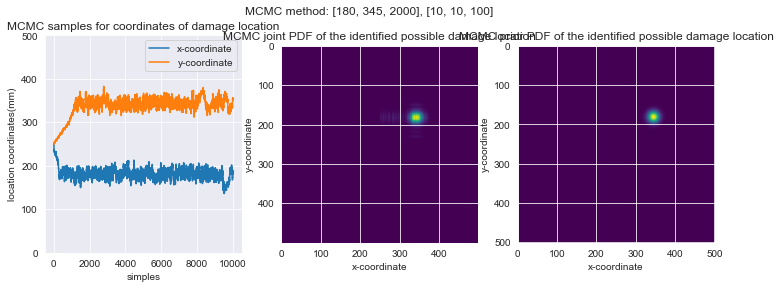

In [10]:
locate = "20180605T150315_D9/pc_f100kHz.h5"
select = np.array([[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10], [0, 11]])

tof = def_multi_tof(locate, select)
theta = def_mcmc(tof, select)

def_plot_fig(theta, '[180, 345, 2000], [10, 10, 100]')